In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor as rf
import xgboost as xgb
import math
import warnings
import model.visualset
import joblib
warnings.filterwarnings('ignore')

In [2]:
model.visualset.Graphset()

In [3]:
# data load
all_df = pd.read_csv('../data/smart_farm.csv')
all_df = all_df.iloc[:,1:]

In [4]:
for colname in all_df.columns:
    newName = colname[11:]
    print(newName)
    all_df.rename(columns={colname:newName},inplace=True)

yy
mm
dd
hh
nn
insolation
out_tmperature
out_humidity
wind_speed
wind_direction
in_tmperature
in_humidity
shield_light_h
shield_tmperature_h
shield_energy_h
shield_energy_v
exhaust_fan
ceiling
floating_fan
fan_coil_b_site
ventilation_temperature_control
heating_temperature_set_up
heat_supply


In [5]:
# 날짜 Index가 여러개 있어서 하나로 정리하고싶을 때 실행
# date = all_df[['yy','mm','dd','hh','nn']].astype(str).apply('-'.join,axis=1)
date = all_df[['yy','mm','dd']].astype(str).apply('-'.join,axis=1)
time = all_df[['hh','nn']].astype(str).apply(':'.join,axis=1)
datetime = date + ' ' + time
all_df.insert(loc=0,column='Dates',value=datetime)
all_df.insert(loc=1,column='Date',value=date)
all_df['Dates'] = pd.to_datetime(all_df['Dates'],format='%Y-%m-%d %H:%M', errors='raise')
all_df['Date'] = pd.to_datetime(all_df['Date'],format='%Y-%m-%d', errors='raise')

<AxesSubplot:>

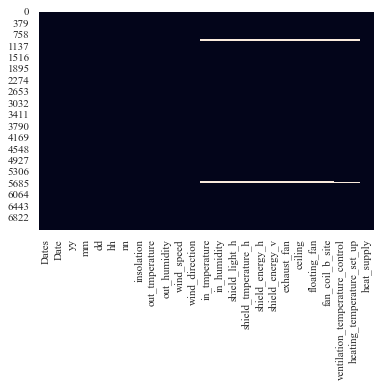

In [77]:
sns.heatmap(all_df[all_df['Date'].dt.month==11].isnull(),cbar=False)

In [106]:
columnlist = all_df.columns[14:23]
columnlist
# all_df.fillna(method='pad',inplace=True)

Index(['shield_light_h', 'shield_tmperature_h', 'shield_energy_h',
       'shield_energy_v', 'exhaust_fan', 'ceiling', 'floating_fan',
       'fan_coil_b_site', 'ventilation_temperature_control'],
      dtype='object')

In [82]:
graph_df = all_df[all_df['Dates'].between('2022-01-26 00:00:00', '2022-01-26 23:59:59')]


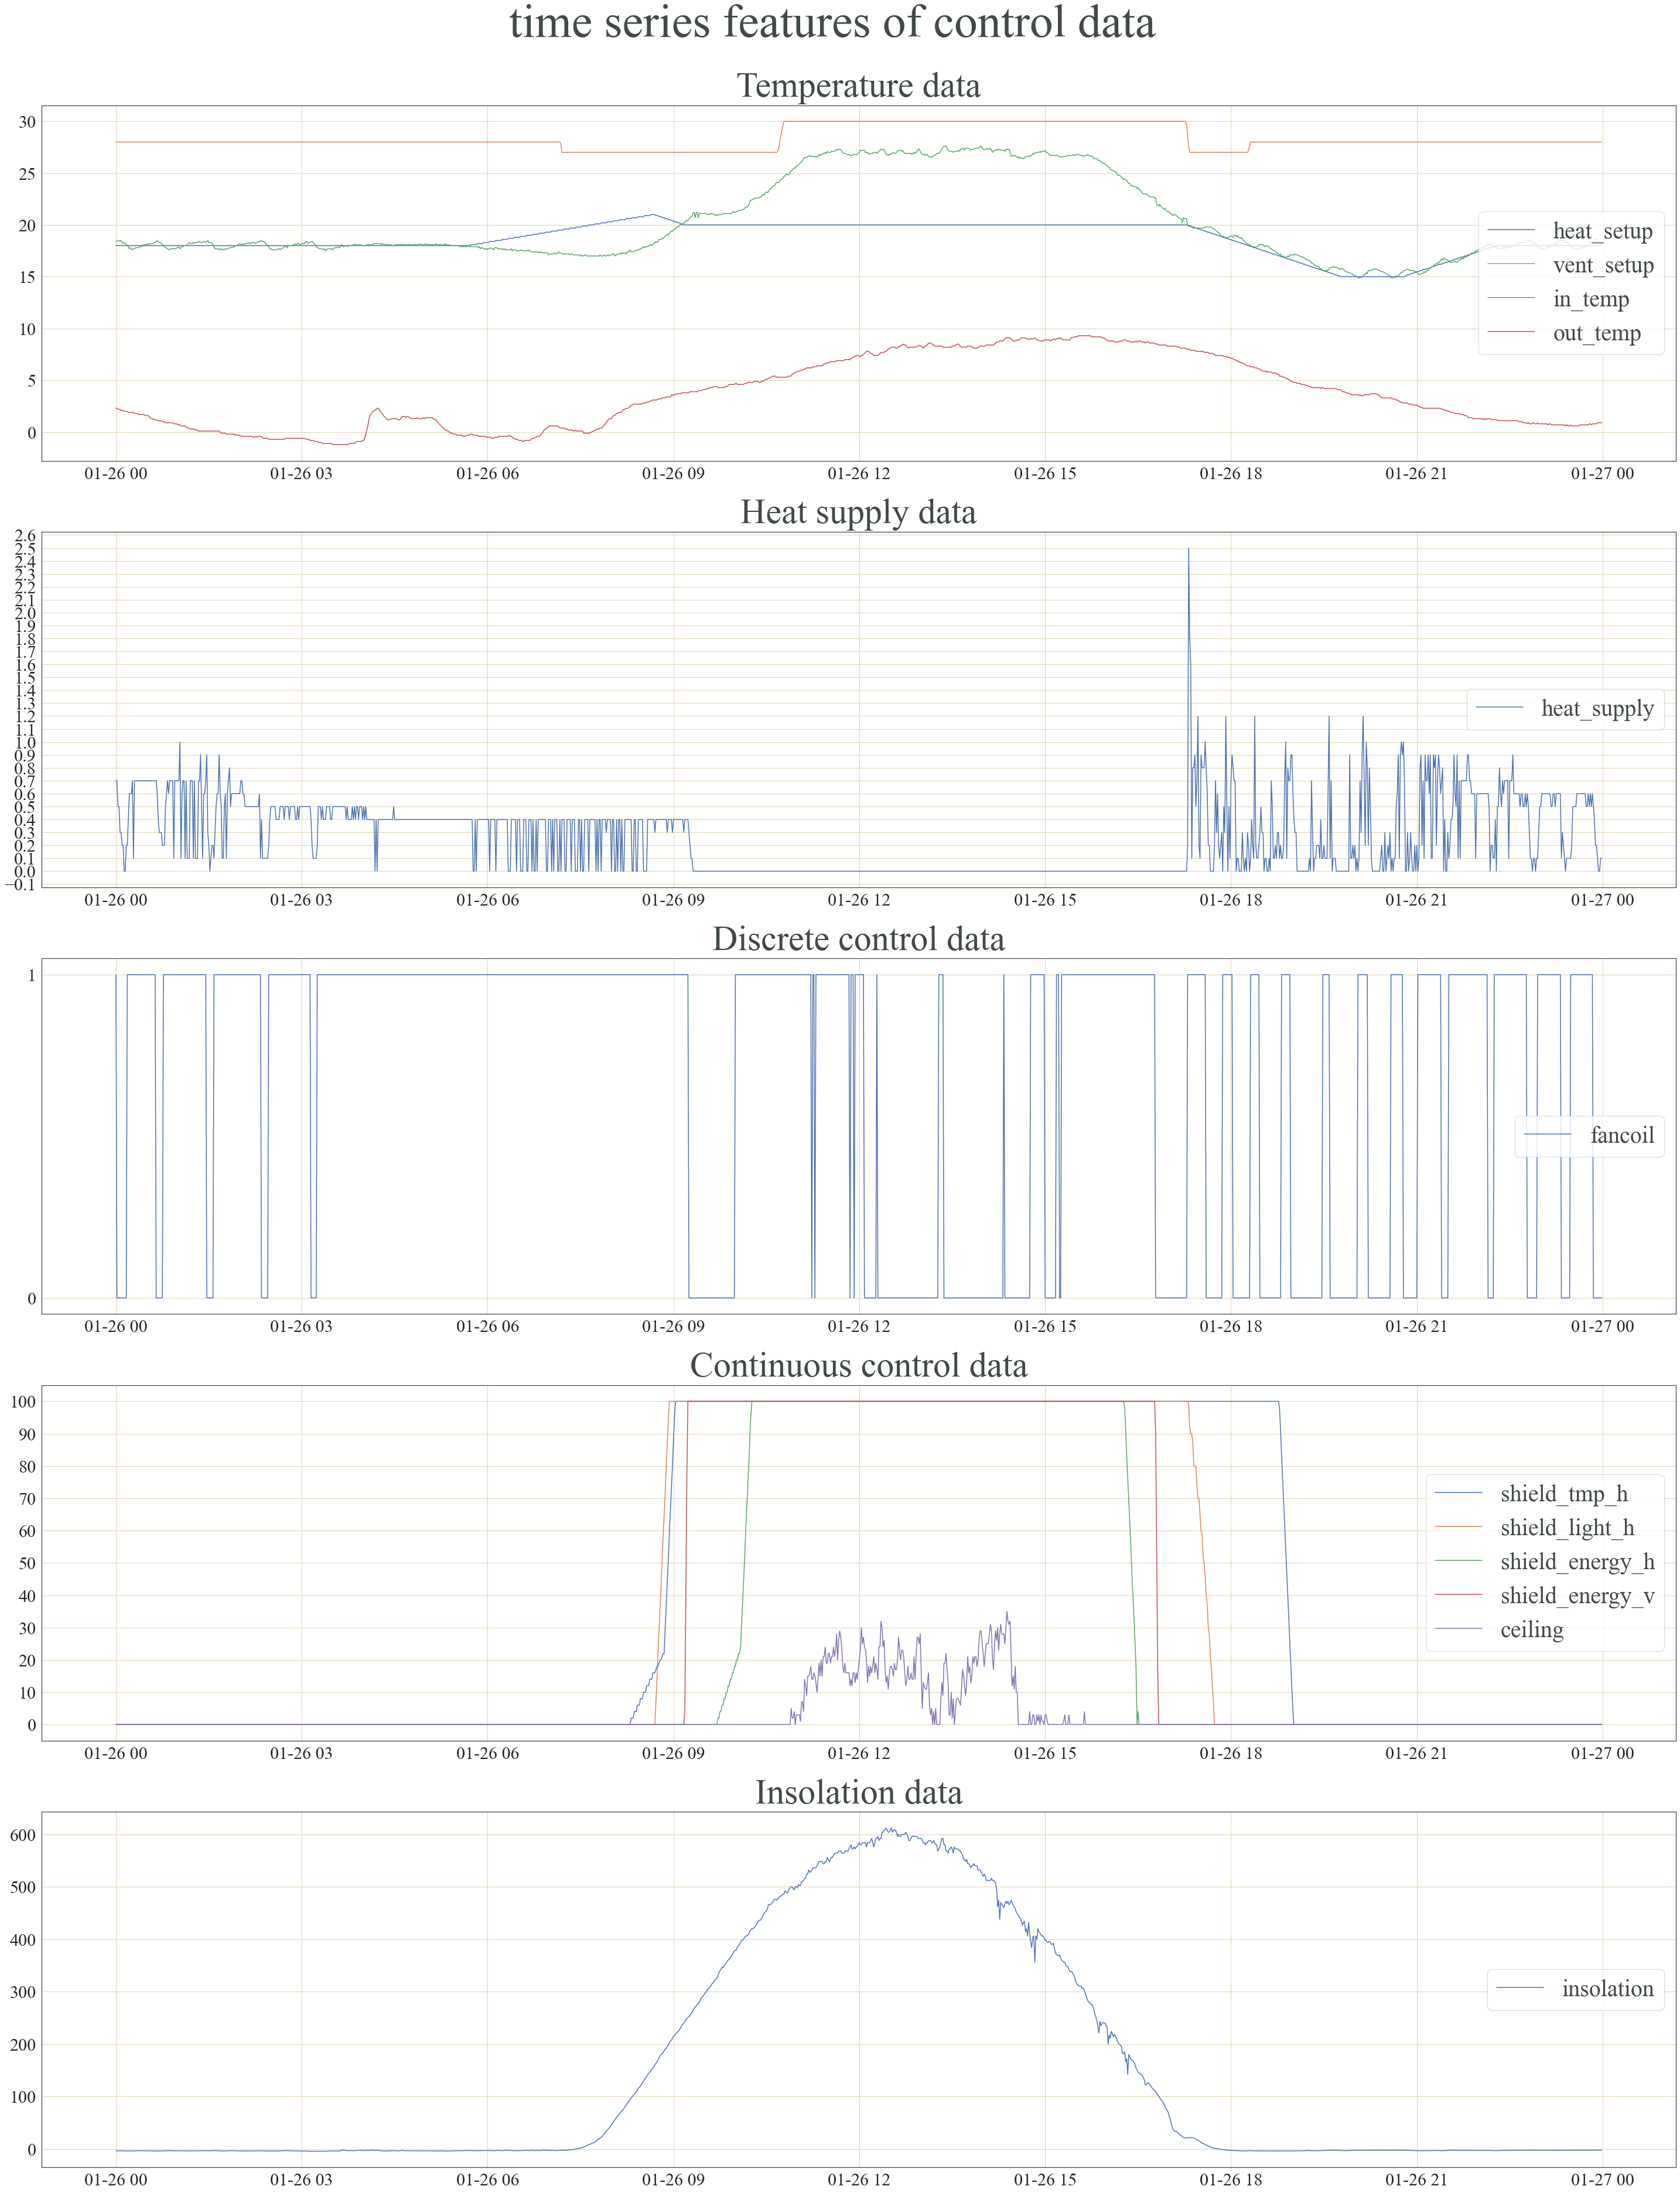

In [83]:
fig, ax = plt.subplots(5,1, figsize=(50,60))


ax[0].plot(graph_df['Dates'],graph_df['heating_temperature_set_up'], label='heat_setup')
ax[0].plot(graph_df['Dates'],graph_df['ventilation_temperature_control'], label='vent_setup')
ax[0].plot(graph_df['Dates'],graph_df['in_tmperature'], label='in_temp')
ax[0].plot(graph_df['Dates'],graph_df['out_tmperature'], label='out_temp')

ax[1].plot(graph_df['Dates'],graph_df['heat_supply'], label='heat_supply')

ax[2].plot(graph_df['Dates'],graph_df['fan_coil_b_site'], label='fancoil')
# ax[2].plot(graph_df['Dates'],graph_df['exhaust_fan'], label='exhaust fan')
# ax[2].plot(graph_df['Dates'],graph_df['floating_fan'], label='floating_fan')

ax[3].plot(graph_df['Dates'],graph_df['shield_tmperature_h'], label='shield_tmp_h')
ax[3].plot(graph_df['Dates'],graph_df['shield_light_h'], label='shield_light_h')
ax[3].plot(graph_df['Dates'],graph_df['shield_energy_h'], label='shield_energy_h')
ax[3].plot(graph_df['Dates'],graph_df['shield_energy_v'], label='shield_energy_v')
ax[3].plot(graph_df['Dates'],graph_df['ceiling'], label='ceiling')

ax[4].plot(graph_df['Dates'],graph_df['insolation'], label='insolation')

for i in range(5):
    ax[i].tick_params(labelsize=30)
    ax[i].legend(loc='center right', prop={'size':40})
    
ax[0].set_title('Temperature data', fontsize=60, pad=15)
ax[1].set_title('Heat supply data', fontsize=60, pad=15)
ax[2].set_title('Discrete control data', fontsize=60, pad=15)
ax[3].set_title('Continuous control data', fontsize=60, pad=15)
ax[4].set_title('Insolation data', fontsize=60, pad=15)

ax[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax[2].yaxis.set_major_locator(ticker.MultipleLocator(1))
ax[3].yaxis.set_major_locator(ticker.MultipleLocator(10))
ax[4].yaxis.set_major_locator(ticker.MultipleLocator(100))

fig.subplots_adjust(top=0.94)
fig.suptitle("time series features of control data",fontsize="80")
fig.savefig("data/graph/time series features of control data.png",bbox_inches='tight',pad_inches=1)

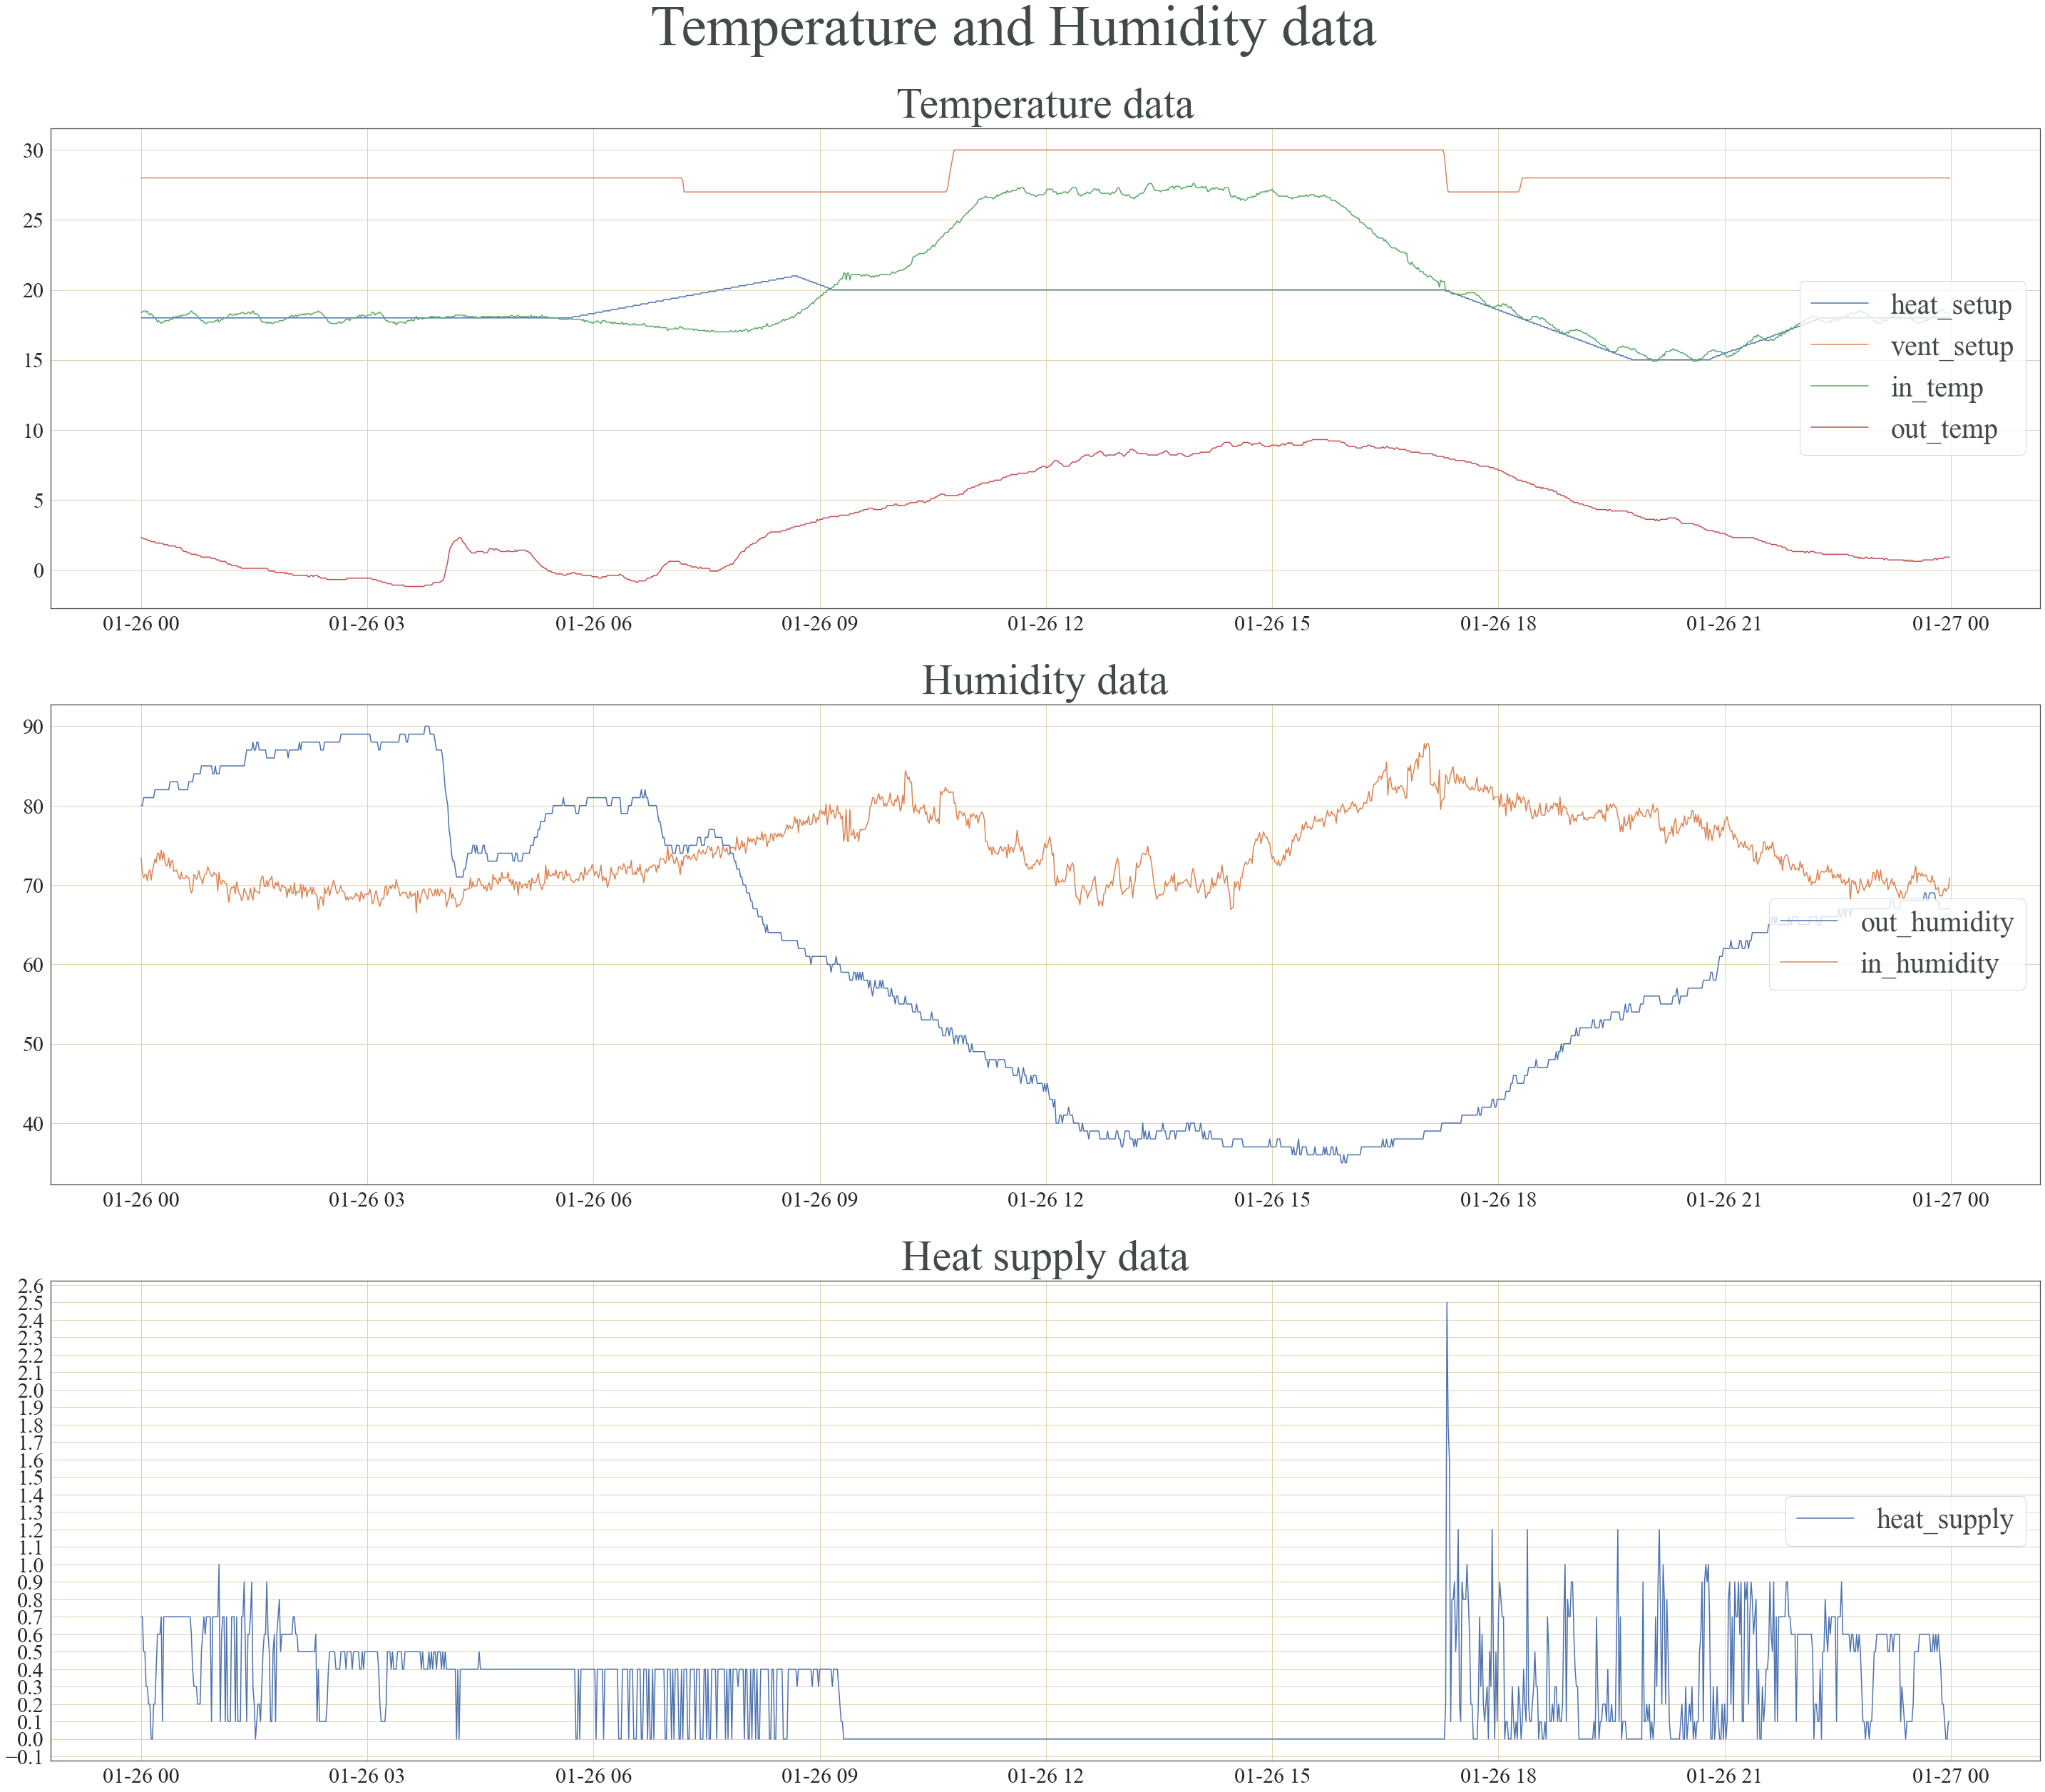

In [92]:
fig2, ax2 = plt.subplots(3,1, figsize=(50,40))


ax2[0].plot(graph_df['Dates'],graph_df['heating_temperature_set_up'], label='heat_setup')
ax2[0].plot(graph_df['Dates'],graph_df['ventilation_temperature_control'], label='vent_setup')
ax2[0].plot(graph_df['Dates'],graph_df['in_tmperature'], label='in_temp')
ax2[0].plot(graph_df['Dates'],graph_df['out_tmperature'], label='out_temp')

ax2[1].plot(graph_df['Dates'],graph_df['out_humidity'], label='out_humidity')
ax2[1].plot(graph_df['Dates'],graph_df['in_humidity'], label='in_humidity')

ax2[2].plot(graph_df['Dates'],graph_df['heat_supply'], label='heat_supply')

for i in range(3):
    ax2[i].tick_params(labelsize=30)
    ax2[i].legend(loc='center right', prop={'size':40})
    
ax2[0].set_title('Temperature data', fontsize=60, pad=15)
ax2[1].set_title('Humidity data', fontsize=60, pad=15)
ax2[2].set_title('Heat supply data', fontsize=60, pad=15)

ax2[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
# ax2[1].yaxis.set_major_locator(ticker.MultipleLocator(1))
ax2[2].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

fig2.subplots_adjust(top=0.92)
fig2.suptitle("Temperature and Humidity data",fontsize="80")
fig2.savefig("data/graph/Temperature and Humidity data.png",bbox_inches='tight',pad_inches=1)

In [107]:
all_df.to_csv("data/df/all_df.csv",index=False)

In [88]:
# 스마트팜 내부제어 요소 리스트
List_Control = ['shield_light_h','shield_tmperature_h','shield_energy_h','shield_energy_v','exhaust_fan','ceiling','floating_fan','fan_coil_b_site','heat_supply']

Index(['shield_light_h', 'shield_tmperature_h', 'shield_energy_h',
       'shield_energy_v', 'exhaust_fan', 'ceiling', 'floating_fan',
       'fan_coil_b_site', 'ventilation_temperature_control'],
      dtype='object')

In [89]:
all_df_corr = all_df.drop(['Dates','Date'],axis=1)
all_df_corr = all_df_corr.corr()

In [14]:
cont_df = all_df[List_Control]
cont_df_corr = cont_df.corr()

<AxesSubplot:>

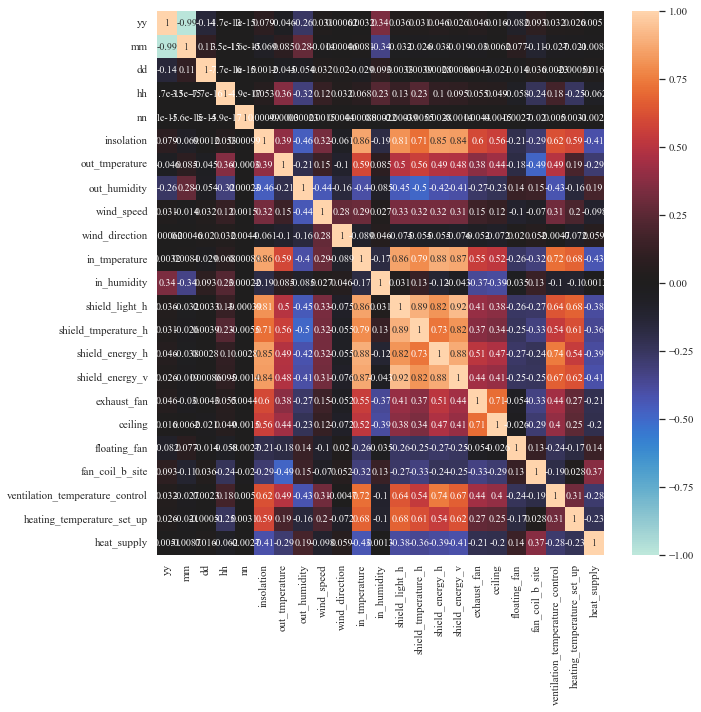

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(all_df_corr,vmax=1, vmin=-1, center=0, annot=True)

<AxesSubplot:>

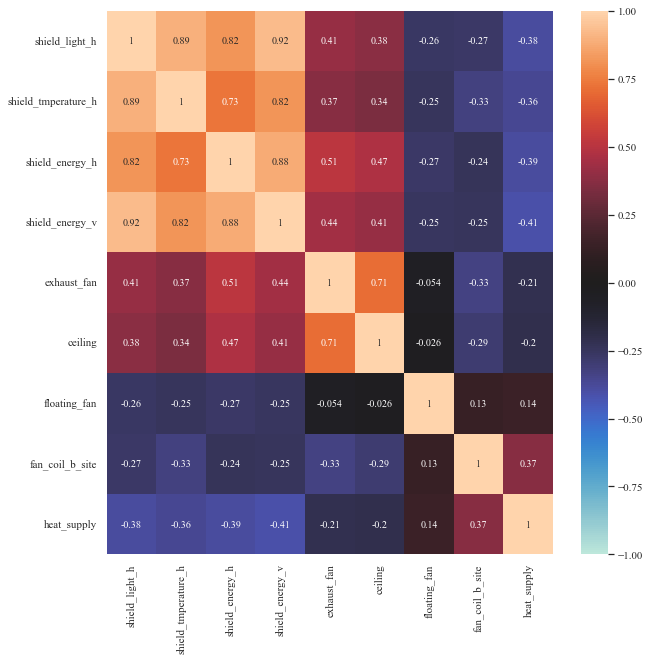

In [16]:
plt.figure(figsize=(10,10))
sns.heatmap(cont_df_corr,vmax=1, vmin=-1, center=0, annot=True)

In [17]:
all_df_corr['heat_supply'].abs().sort_values(ascending=False)

heat_supply                        1.000000
in_tmperature                      0.433335
shield_energy_v                    0.408185
insolation                         0.408037
shield_energy_h                    0.388191
shield_light_h                     0.384404
fan_coil_b_site                    0.373128
shield_tmperature_h                0.364154
out_tmperature                     0.291589
ventilation_temperature_control    0.282265
heating_temperature_set_up         0.230081
exhaust_fan                        0.214179
ceiling                            0.204157
out_humidity                       0.187190
floating_fan                       0.140951
wind_speed                         0.097829
hh                                 0.062197
wind_direction                     0.059303
dd                                 0.015692
mm                                 0.008736
yy                                 0.005080
nn                                 0.002713
in_humidity                     

<AxesSubplot:>

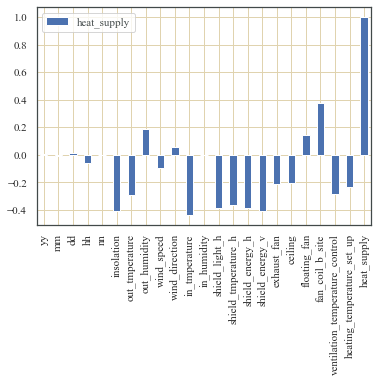

In [18]:
all_df_corr.plot.bar(y='heat_supply')

In [19]:
control_per_hour = all_df[['hh','shield_energy_h','shield_energy_v','fan_coil_b_site','shield_light_h','heat_supply']].groupby('hh').mean()
control_per_hour['heat_supply'] = control_per_hour['heat_supply'] * 60
control_per_hour

,shield_energy_h,shield_energy_v,fan_coil_b_site,shield_light_h,heat_supply
hh,,,,,
0,0.000000,0.056604,0.793868,0.000000,28.303242
1,0.000000,0.056604,0.806132,0.000000,27.679705
2,0.000000,0.056604,0.817138,0.000000,27.430356
3,0.000000,0.056604,0.834277,0.000000,28.015247
4,0.000000,0.056604,0.847937,0.000000,27.014746
5,0.000000,0.056604,0.899371,0.000000,27.564130
6,0.000000,0.056630,0.956426,0.000000,28.511180
7,0.000000,1.846276,0.967737,0.445833,28.470652
8,1.760410,21.452366,0.837066,32.355994,24.828261


In [20]:
from model.train import trainer
from model.predict import predictor
import yaml
with open('model/setting/params.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

In [93]:
train_df = all_df
train_df.to_csv('data/df/train_df.csv',index=False)

In [22]:
# train_X = train_df.drop(['Dates', 'heat_supply'],axis=1)
# train_Y = train_df['heat_supply']

In [96]:
test1_df = all_df[all_df['Dates'].between('2022-03-04 00:00:00', '2022-03-13 23:59:59')]
test2_df = all_df[all_df['Dates'].between('2022-03-18 00:00:00', '2022-03-20 23:59:59')]

test1_df.to_csv("data/df/test1_df.csv",index=False)
test2_df.to_csv("data/df/test2_df.csv",index=False)

test1_X = test1_df.drop(['Dates', 'heat_supply'],axis=1)
test2_X = test2_df.drop(['Dates', 'heat_supply'],axis=1)

In [24]:
# test2_df.head()

In [25]:
# tr = trainer()
# pred = predictor()

# tr.train_lgb(train_X, train_Y, params['lgb'])

In [26]:
# pred.predict_lgb(tr.models_lgb[0], test1_X)
# pred.predict_lgb(tr.models_lgb[0], test2_X)

In [27]:

cont_df = all_df[List_Control]
cont_df = cont_df.dropna(axis=0)[List_Control]
cont_X = cont_df.iloc[:,:-1]
cont_y = cont_df.iloc[:,-1]


In [28]:
# cont_X.shape

In [29]:
# X_train, X_test, y_train, y_test = train_test_split(cont_X, cont_y, test_size = 0.2, random_state=1)
# model_linear = LinearRegression()
# model_linear.fit(X_train, y_train)

In [30]:
# X_pred = model_linear.predict(X_test)


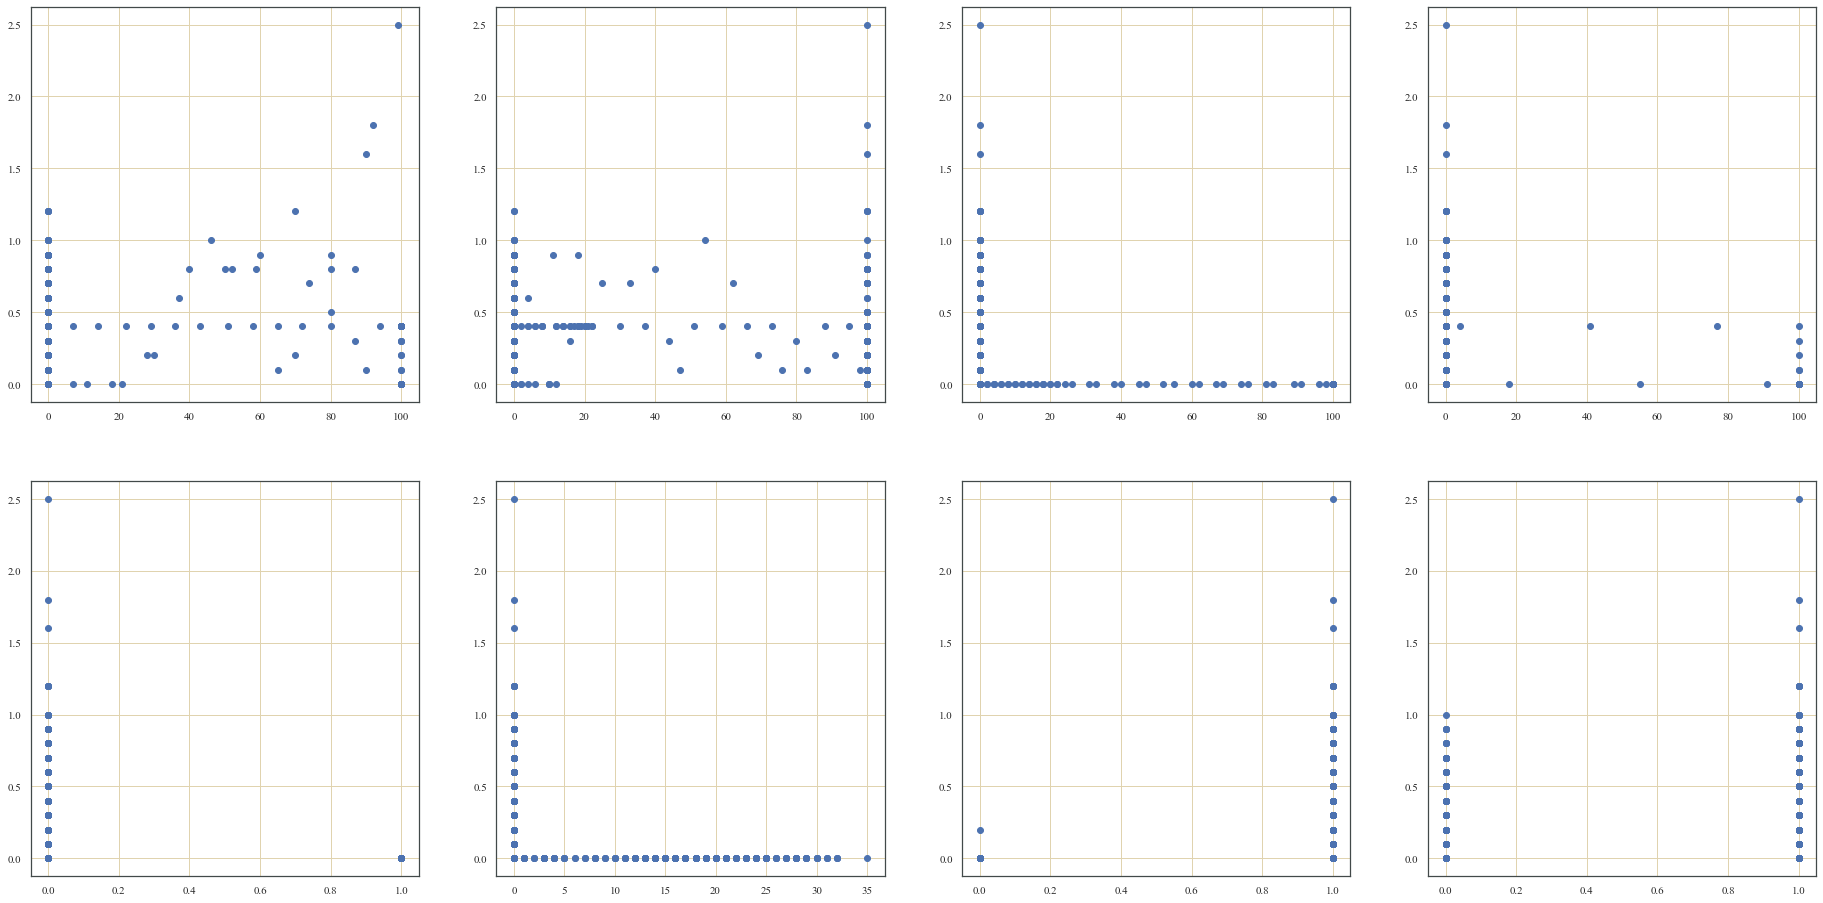

In [31]:
##그래프로 시각화해보기
fig, ax = plt.subplots(2,4, figsize=(32, 16))    
ax[0][0].scatter(graph_df['shield_light_h'],graph_df['heat_supply'])
ax[0][1].scatter(graph_df['shield_tmperature_h'],graph_df['heat_supply'])
ax[0][2].scatter(graph_df['shield_energy_h'],graph_df['heat_supply'])
ax[0][3].scatter(graph_df['shield_energy_v'],graph_df['heat_supply'])
ax[1][0].scatter(graph_df['exhaust_fan'],graph_df['heat_supply'])
ax[1][1].scatter(graph_df['ceiling'],graph_df['heat_supply'])
ax[1][2].scatter(graph_df['floating_fan'],graph_df['heat_supply'])
ax[1][3].scatter(graph_df['fan_coil_b_site'],graph_df['heat_supply'])

# x와 예측 데이터 값으로 그래프 그리기
# ax[1].plot(, X_pred, color='b')

# ax[1].set_xlabel('x')
# ax[1].set_ylabel('y')

In [32]:
# y_test_pred = model_linear.predict(X_test)
# mse = mean_squared_error(y_test, y_test_pred)
# rmse = math.sqrt(mse)
# print(rmse)


In [98]:
from model.predict import predictor
pred = predictor()
lgb_model = joblib.load('data/model/lgb_model')
xgb_model = joblib.load('data/model/xgb_model')

# test_1_df = all_df[all_df['Dates'].between('2021-12-26 00:00:00', '2021-12-26 23:59:59')]

test_1_X = graph_df.drop(['Dates','Date', 'heat_supply'],axis=1)

pred_lgb_df = pd.DataFrame(pred.predict_lgb(lgb_model, test_1_X))
pred_xgb_df = pd.DataFrame(pred.predict_xgb(xgb_model, test_1_X))


In [34]:
test_1_X.shape

(1440, 22)

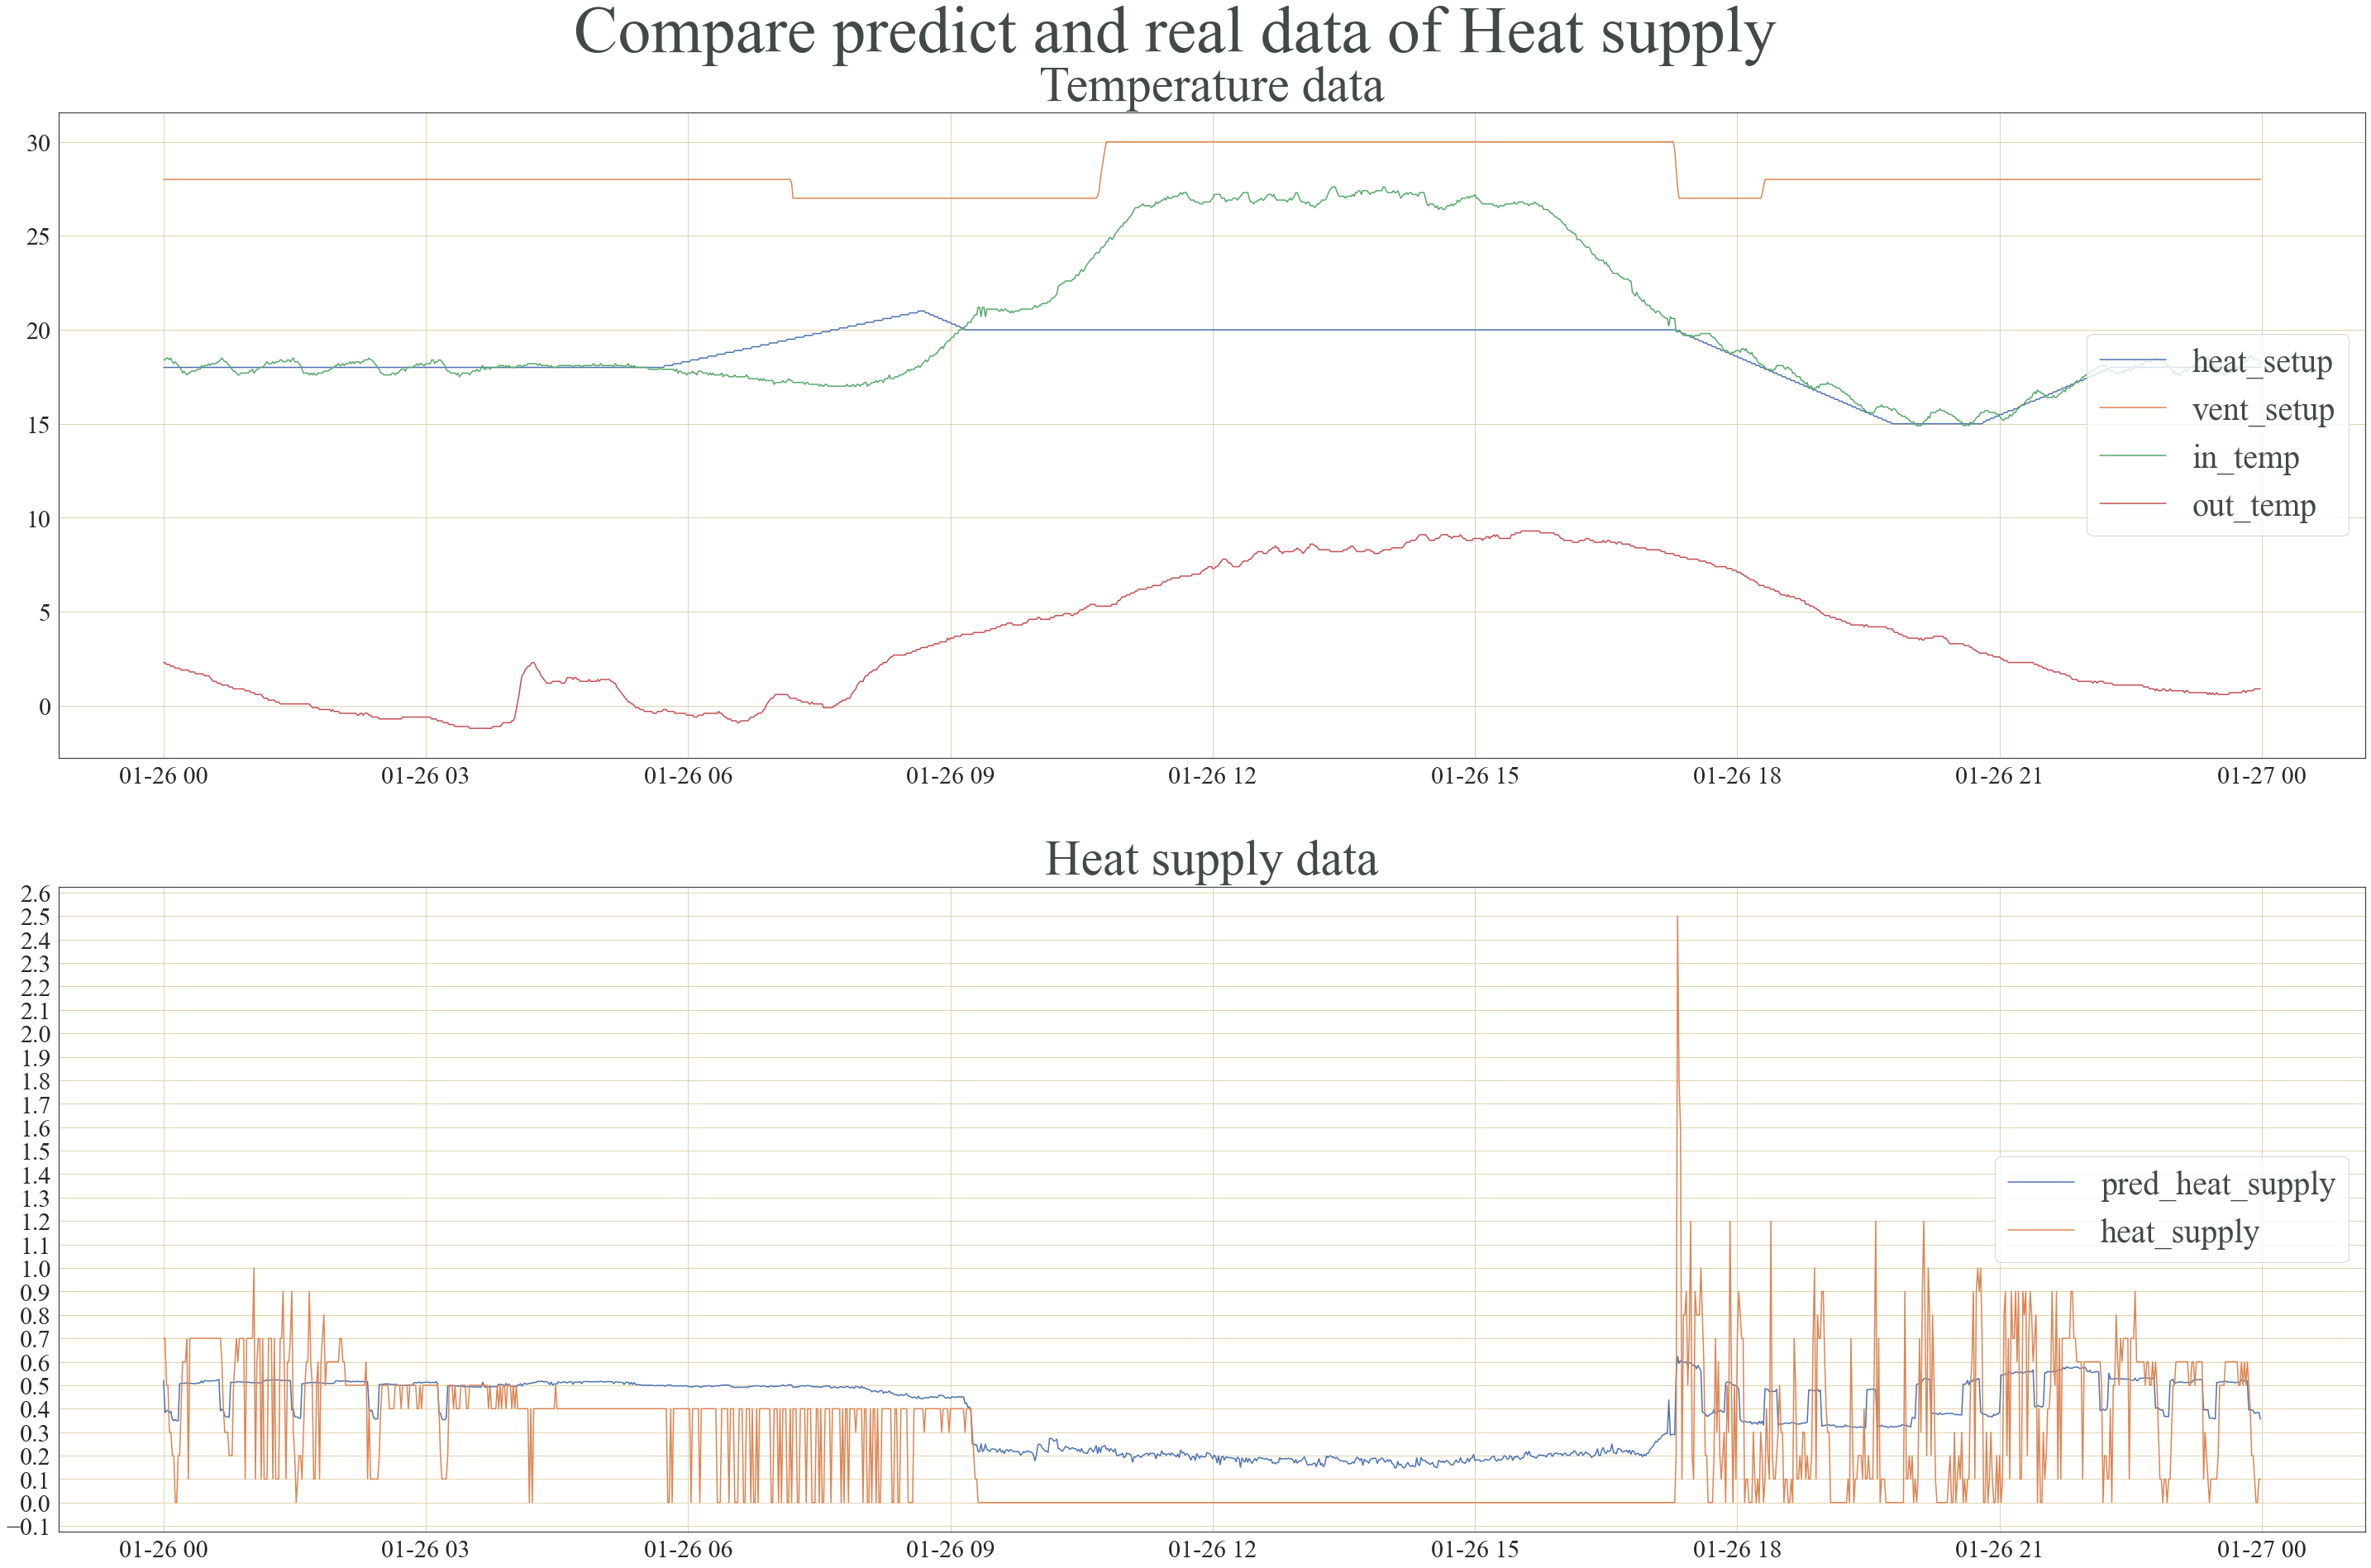

In [100]:
fig3, ax3 = plt.subplots(2,1, figsize=(50,30))


ax3[0].plot(graph_df['Dates'],graph_df['heating_temperature_set_up'], label='heat_setup')
ax3[0].plot(graph_df['Dates'],graph_df['ventilation_temperature_control'], label='vent_setup')
ax3[0].plot(graph_df['Dates'],graph_df['in_tmperature'], label='in_temp')
ax3[0].plot(graph_df['Dates'],graph_df['out_tmperature'], label='out_temp')

ax3[1].plot(graph_df['Dates'],pred_xgb_df, label='pred_heat_supply')
ax3[1].plot(graph_df['Dates'],graph_df['heat_supply'], label='heat_supply')

for i in range(2):
    ax3[i].tick_params(labelsize=30)
    ax3[i].legend(loc='center right', prop={'size':40})
    
ax3[0].set_title('Temperature data', fontsize=60, pad=15)
ax3[1].set_title('Heat supply data', fontsize=60, pad=15)

ax3[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
ax3[1].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

fig3.subplots_adjust(top=0.92)
fig3.suptitle("Compare predict and real data of Heat supply",fontsize="80")
fig3.savefig("data/graph/Compare predict and real data of Heat supply",bbox_inches='tight',pad_inches=1)

In [ ]:
# graph_df.loc[graph_df['Dates'].between('2022-01-26 00:00:00', '2022-01-26 23:59:59'),'']

In [ ]:
all_df

hihi